In [9]:
import os, json
import pickle
import pandas as pd
import numpy as  np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.special as sp
from sklearn.metrics import classification_report

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [10]:
# !pip install pymc

In [11]:
# ! pip install arviz

In [12]:
# !pip install graphviz

In [13]:
# !apt-get install graphviz -y

## Data

In [14]:
DATA_PATH='data/raw/'
df=pd.DataFrame()
for file in os.listdir(DATA_PATH):
    df_=pd.read_csv(f'{DATA_PATH}{file}')
    df=pd.concat([df, df_])
df.shape

(180524, 13)

In [15]:
df.head(10)

,EKSAMI_SOORITAJA,KUUPAEV,BYROO,KATEGOORIA,ERITINGIMUSED,VIIMANE_AUTOKOOL,SOIDUOPETAJA_KAASAS,EKSAMINEERIJA,SEISUND,KESTUS,KATK_POHJUS,MITTEARVESTATUD,VEAD
0,fb6f44a4e71821f2,2023-01,Valga,B,101,osaühing Kursus & Ko,E,bf2b7218d36e2a3d,MITTE_SOORITATUD,28.0,NaN,LIIKLUSOHUTUS|TEELPUSIMINE,NaN
1,82ed52e5990f8204,2023-01,Jõgeva,B,101,OÜ AUTOSÕIT,E,844452b4e4bac2ef,SOORITATUD,44.0,NaN,NaN,NaN
2,e72eeaf255d74785,2023-01,Narva,B,101|78,OSAÜHING ERMAN AUTOKOOL,E,d67d168bc8d04278,SOORITATUD,45.0,NaN,NaN,NaN
3,d0dd38daf0397c9d,2023-01,Valga,B,101,osaühing Kursus & Ko,J,bf2b7218d36e2a3d,MITTE_SOORITATUD,33.0,NaN,LIIKLUSOHUTUS,NaN
4,655194a10a21cd56,2023-01,Paide,B,101|78,Autokool Drive OÜ,E,f6097462dafbd97c,MITTE_SOORITATUD,18.0,NaN,PARKIMINE_MANOOVRIGA,EBAPIISAV_ETTEVALMISTUS|PARKIMINE_MARGISEL
5,761396cbfe80ec42,2023-01,Valga,B,101,osaühing Kursus & Ko,E,faeaf99580d6be30,SOORITATUD,42.0,NaN,NaN,NaN
6,de824d8083a1d269,2023-01,Rapla,B,101,Silver Autokool OÜ,E,4b9e369e12d8f969,SOORITATUD,49.0,NaN,NaN,NaN
7,44e0c0d162afebb0,2023-01,Narva,B,101,Osaühing STALIKA-VEOD,E,166c8268fe1b2ec1,SOORITATUD,41.0,NaN,NaN,NaN
8,808f4666542a6bc8,2023-01,Narva,B,101,Mittetulundusühing Autobis,E,166c8268fe1b2ec1,MITTE_SOORITATUD,47.0,NaN,LIIKLUSOHUTUS|PARKIMINE_MANOOVRIGA,OHUSTAMINE
9,cdc8a8cc2ddeca47,2023-01,Tartu,B,101|78,ROPKA ERAKOOL OÜ,NaN,c68c6310b2fe1124,EI_ILMUNUD_KOHALE,NaN,EI_ILMUNUD,NaN,NaN


In [16]:
df.tail(10)

,EKSAMI_SOORITAJA,KUUPAEV,BYROO,KATEGOORIA,ERITINGIMUSED,VIIMANE_AUTOKOOL,SOIDUOPETAJA_KAASAS,EKSAMINEERIJA,SEISUND,KESTUS,KATK_POHJUS,MITTEARVESTATUD,VEAD
43899,2d3d0275e6f87c93,2024-01,Tallinn,C,NaN,Aktsiaselts Odium,E,a1d9e404aeec83d1,SOORITATUD,58.0,NaN,NaN,NaN
43900,662c8bfc52935409,2024-08,Tartu,C,NaN,OÜ AUTOSÕIT,E,b89f5e763b05e7a7,MITTE_SOORITATUD,4.0,NaN,TAGUR_BOKS,VASTU_KOONUST
43901,8431c357abeb9177,2024-05,Tallinn,A,NaN,Ametikoolitus OÜ,E,b353c311e671711a,SOORITATUD,44.0,NaN,NaN,NaN
43902,41f599b18e8d11a3,2024-09,Rapla,A,NaN,Rapla Autokool OÜ,E,b353c311e671711a,SOORITATUD,43.0,NaN,NaN,NaN
43903,7ba322b8b5eb8552,2024-02,Pärnu,CE,NaN,osaühing Aide Autokool,E,c347692cf48342d6,SOORITATUD,64.0,NaN,NaN,NaN
43904,2455ec4557fca42a,2024-02,Jõhvi,C,NaN,Tõnis Mägi Autokool OÜ,E,268b141c418a500d,SOORITATUD,53.0,NaN,NaN,NaN
43905,15758d080522a0f9,2024-08,Tallinn,A,NaN,Ametikoolitus OÜ,E,b353c311e671711a,SOORITATUD,50.0,NaN,NaN,NaN
43906,dd65c5b9c581747f,2024-05,Tallinn,A,NaN,Sky Autokool OÜ,NaN,c68c6310b2fe1124,EI_ILMUNUD_KOHALE,NaN,EI_ILMUNUD,NaN,NaN
43907,b9f5d194b08c7496,2024-03,Jõhvi,C,NaN,OÜ AUTOSÕIT,E,c74b0de43bcd0b0f,SOORITATUD,55.0,NaN,NaN,NaN
43908,4674e35f5ec54f3f,2024-10,Võru,C,NaN,Tugev Partner OÜ,E,5f2e29794998d365,SOORITATUD,60.0,NaN,NaN,NaN


In [17]:
df.describe(include='all')

,EKSAMI_SOORITAJA,KUUPAEV,BYROO,KATEGOORIA,ERITINGIMUSED,VIIMANE_AUTOKOOL,SOIDUOPETAJA_KAASAS,EKSAMINEERIJA,SEISUND,KESTUS,KATK_POHJUS,MITTEARVESTATUD,VEAD
count,180524,180524,180524,180524,129745,170298,175589,180524,180524,175214.000000,5320,77419,18738
unique,91167,47,17,14,11,366,2,59,4,NaN,7,2726,418
top,2a1562b30ea0f71a,2022-05,Tallinn,B,101,OÜ AUTOSÕIT,E,bf2b7218d36e2a3d,SOORITATUD,NaN,EI_ILMUNUD,LIIKLUSOHUTUS,AJA_YLETAMINE
freq,23,4792,68889,128633,96651,18021,165004,5320,97720,NaN,3275,11518,2724
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,38.991182,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.175641,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26.000000,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,43.000000,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.000000,NaN,NaN,NaN


## cols2keep

In [18]:
df_b=df[(df.KATEGOORIA=='B')&(df.SEISUND.isin(['MITTE_SOORITATUD', 'SOORITATUD']))]
df_b.shape

(124702, 13)

In [19]:
COLS2KEEP=['KUUPAEV', 'BYROO', 'ERITINGIMUSED','VIIMANE_AUTOKOOL','SOIDUOPETAJA_KAASAS', 'EKSAMINEERIJA', 'SEISUND']

In [20]:
df_b_sub=df_b[COLS2KEEP]

In [21]:
df_b_sub.head(10)

,KUUPAEV,BYROO,ERITINGIMUSED,VIIMANE_AUTOKOOL,SOIDUOPETAJA_KAASAS,EKSAMINEERIJA,SEISUND
0,2023-01,Valga,101,osaühing Kursus & Ko,E,bf2b7218d36e2a3d,MITTE_SOORITATUD
1,2023-01,Jõgeva,101,OÜ AUTOSÕIT,E,844452b4e4bac2ef,SOORITATUD
2,2023-01,Narva,101|78,OSAÜHING ERMAN AUTOKOOL,E,d67d168bc8d04278,SOORITATUD
3,2023-01,Valga,101,osaühing Kursus & Ko,J,bf2b7218d36e2a3d,MITTE_SOORITATUD
4,2023-01,Paide,101|78,Autokool Drive OÜ,E,f6097462dafbd97c,MITTE_SOORITATUD
5,2023-01,Valga,101,osaühing Kursus & Ko,E,faeaf99580d6be30,SOORITATUD
6,2023-01,Rapla,101,Silver Autokool OÜ,E,4b9e369e12d8f969,SOORITATUD
7,2023-01,Narva,101,Osaühing STALIKA-VEOD,E,166c8268fe1b2ec1,SOORITATUD
8,2023-01,Narva,101,Mittetulundusühing Autobis,E,166c8268fe1b2ec1,MITTE_SOORITATUD
10,2023-01,Valga,101,OÜ AUTOSÕIT,E,ae264be409f2ca9f,SOORITATUD


In [22]:
df_b_sub.tail(10)

,KUUPAEV,BYROO,ERITINGIMUSED,VIIMANE_AUTOKOOL,SOIDUOPETAJA_KAASAS,EKSAMINEERIJA,SEISUND
43824,2024-03,Haapsalu,NaN,NaN,J,31451a368e962058,SOORITATUD
43825,2024-07,Valga,NaN,NaN,E,844452b4e4bac2ef,SOORITATUD
43850,2024-03,Tartu,NaN,VPK Koolitus OÜ,E,b89f5e763b05e7a7,SOORITATUD
43855,2024-03,Tartu,NaN,VPK Koolitus OÜ,E,5f2e29794998d365,SOORITATUD
43858,2024-10,Narva,NaN,NaN,E,166c8268fe1b2ec1,SOORITATUD
43860,2024-10,Kärdla,NaN,Aivar Tärk Autokool,E,31451a368e962058,SOORITATUD
43861,2024-06,Pärnu,NaN,NaN,E,c347692cf48342d6,MITTE_SOORITATUD
43869,2024-04,Pärnu,NaN,osaühing Aide Autokool,E,12ed0758e403a7d6,SOORITATUD
43871,2024-08,Tartu,NaN,VPK Koolitus OÜ,E,b89f5e763b05e7a7,SOORITATUD
43882,2024-11,Tartu,NaN,VPK Koolitus OÜ,E,ea58f592917668cf,SOORITATUD


In [23]:
df_b_sub.describe(include='all')

,KUUPAEV,BYROO,ERITINGIMUSED,VIIMANE_AUTOKOOL,SOIDUOPETAJA_KAASAS,EKSAMINEERIJA,SEISUND
count,124702,124702,120919,120021,124702,124702,124702
unique,47,17,7,353,2,58,2
top,2022-03,Tallinn,101,OÜ AUTOSÕIT,E,c6d0f1ea0c1f7aec,MITTE_SOORITATUD
freq,3389,47397,91516,12700,115230,5024,64273


In [24]:
df_b_sub.SEISUND.value_counts()

SEISUND
MITTE_SOORITATUD    64273
SOORITATUD          60429
Name: count, dtype: int64

In [25]:
df_b[df_b.SEISUND=='KATKESTATUD']

,EKSAMI_SOORITAJA,KUUPAEV,BYROO,KATEGOORIA,ERITINGIMUSED,VIIMANE_AUTOKOOL,SOIDUOPETAJA_KAASAS,EKSAMINEERIJA,SEISUND,KESTUS,KATK_POHJUS,MITTEARVESTATUD,VEAD


## Keep eritingimused 101, 78

In [26]:
df_b_sub['eri_101']=np.where(df_b_sub.ERITINGIMUSED.str.contains('101'), 1, 0)
df_b_sub['eri_78']=np.where(df_b_sub.ERITINGIMUSED.str.contains('78'), 1, 0)
df_b_sub['eri_78_c'] = df_b_sub['eri_78'] - df_b_sub['eri_78'].mean()

/tmp/ipykernel_86/937150852.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_b_sub['eri_101']=np.where(df_b_sub.ERITINGIMUSED.str.contains('101'), 1, 0)
/tmp/ipykernel_86/937150852.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_b_sub['eri_78']=np.where(df_b_sub.ERITINGIMUSED.str.contains('78'), 1, 0)
/tmp/ipykernel_86/937150852.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cavea

In [27]:
df_b_sub.shape

(124702, 10)

In [28]:
df_b_sub=df_b_sub[df_b_sub.eri_101==1]
df_b_sub.shape

(122315, 10)

In [29]:
df_b_sub['eri_96']=np.where(df_b_sub.ERITINGIMUSED.str.contains('96'), 1, 0)
df_b_sub=df_b_sub[df_b_sub.eri_96==0]
df_b_sub.shape

(118532, 11)

## Recode y

In [30]:
df_b_sub['y']=df_b_sub.SEISUND.replace({'SOORITATUD':1.0, 'MITTE_SOORITATUD':0.0})

/tmp/ipykernel_86/645445151.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_b_sub['y']=df_b_sub.SEISUND.replace({'SOORITATUD':1.0, 'MITTE_SOORITATUD':0.0})


In [31]:
df_b_sub.shape

(118532, 12)

In [32]:
df_b_sub.SEISUND.value_counts()

SEISUND
MITTE_SOORITATUD    61437
SOORITATUD          57095
Name: count, dtype: int64

In [33]:
epsilon = 1e-6  # small constant to avoid direct 0
df_b_sub['y_transformed'] =df_b_sub['y']* (1 - 2*epsilon) + epsilon

## Recode others

In [34]:
df_b_sub['VIIMANE_AUTOKOOL'] = df_b_sub['VIIMANE_AUTOKOOL'].fillna('UNKNOWN')

count_examiner=df_b_sub['EKSAMINEERIJA'].str.lower().value_counts()
examiners2keep=count_examiner[count_examiner>20].index
df_b_sub['EKSAMINEERIJA_CLEAN'] = np.where(df_b_sub['EKSAMINEERIJA'].isin(examiners2keep), df_b_sub['EKSAMINEERIJA'], 'grupp')

examiner_to_idx = {examiner: idx for idx, examiner in enumerate(df_b_sub['EKSAMINEERIJA_CLEAN'].unique())}
idx_to_examiner={v:k for k,v in examiner_to_idx.items()}
school_to_idx = {school: idx for idx, school in enumerate(df_b_sub['VIIMANE_AUTOKOOL'].str.lower().unique())}
idx_to_school={v:k for k,v in school_to_idx.items()}

# Convert categories to indices
df_b_sub['examiner_idx'] = df_b_sub['EKSAMINEERIJA_CLEAN'].map(examiner_to_idx)
df_b_sub['school_idx'] = df_b_sub['VIIMANE_AUTOKOOL'].str.lower().map(school_to_idx)

# Convert target to binary
df_b_sub['passed'] = (df_b_sub['SEISUND'] == 'SOORITATUD').astype(int)

In [35]:
count_schools=df_b_sub['VIIMANE_AUTOKOOL'].str.lower().value_counts()
count_schools[count_schools>20]

VIIMANE_AUTOKOOL
oü autosõit                              12519
osaühing aide autokool                    4439
atlanta autokool oü                       4022
aktsiaselts odium                         3548
sky autokool oü                           3085
                                         ...  
vana-vigala tehnika- ja teeninduskool       23
osaühing kalju autokool                     22
mareki autokool oü                          22
a-autom, oü                                 21
oü horizontrans                             21
Name: count, Length: 226, dtype: int64

In [36]:
# First create index mapping for BYROO
byroo_to_idx = {byroo: idx for idx, byroo in enumerate(df_b_sub['BYROO'].unique())}
idx_to_byroo={v:k for k,v in byroo_to_idx.items()}
n_byroos = len(byroo_to_idx)
# Convert BYROO to indices
df_b_sub['byroo_idx'] = df_b_sub['BYROO'].map(byroo_to_idx)

In [37]:
byroo_to_idx

{'Valga': 0,
 'Jõgeva': 1,
 'Narva': 2,
 'Paide': 3,
 'Rapla': 4,
 'Tartu': 5,
 'Tallinn': 6,
 'Võru': 7,
 'Jõhvi': 8,
 'Põlva': 9,
 'Rakvere': 10,
 'Kuressaare': 11,
 'Viljandi': 12,
 'Haapsalu': 13,
 'Pärnu': 14,
 'Kärdla': 15,
 'Saue': 16}

In [38]:
# Get dimensions for our hierarchical components
n_examiners = len(examiner_to_idx)
n_schools = len(school_to_idx)

In [39]:
n_examiners

56

## Soiduopetaja kaasas

In [40]:
df_b_sub.groupby('SOIDUOPETAJA_KAASAS')['y'].mean()

SOIDUOPETAJA_KAASAS
E    0.487638
J    0.401513
Name: y, dtype: float64

In [41]:
df_b_sub['teacher_present'] = (df_b_sub['SOIDUOPETAJA_KAASAS'] == 'J').astype(int)
#for faster sampling
df_b_sub['teacher_present_c'] = df_b_sub['teacher_present'] - df_b_sub['teacher_present'].mean()

## Model

In [47]:
with pm.Model() as model:
    intercept_raw = pm.Normal('intercept_raw', mu=0, sigma=1)
    intercept_sigma = pm.HalfStudentT('intercept_sigma', nu=3, sigma=0.05)
    intercept = pm.Deterministic('intercept', intercept_raw * intercept_sigma)
    
    examiner_sigma = pm.HalfCauchy('examiner_sigma', beta=0.05)
    examiner_raw = pm.Normal('examiner_raw', mu=0, sigma=1, shape=n_examiners)
    examiner_effects = pm.Deterministic('examiner_effects', examiner_raw * examiner_sigma)
    
    school_sigma = pm.HalfStudentT('school_sigma', nu=3, sigma=0.5)
    school_raw = pm.Normal('school_raw', mu=0, sigma=1, shape=n_schools)
    school_effects = pm.Deterministic('school_effects', school_raw * school_sigma)
    
    byroo_sigma = pm.HalfStudentT('byroo_sigma', nu=3, sigma=0.1)
    byroo_raw = pm.Normal('byroo_raw', mu=0, sigma=1, shape=n_byroos)
    byroo_effects = pm.Deterministic('byroo_effects', byroo_raw * byroo_sigma)
    
    teacher_effect = pm.Normal('teacher_effect', mu=0, sigma=0.5)
    
    # Combine all predictors
    logit = (intercept + 
             examiner_effects[df_b_sub['examiner_idx']] +
             school_effects[df_b_sub['school_idx']] +
             byroo_effects[df_b_sub['byroo_idx']] +
             teacher_effect*df_b_sub['teacher_present_c']
            )
        
     # Transform mu to be between 0 and 1
    mu_bounded = pm.math.invlogit(logit)
    
    # Use transformed data with Beta likelihood
    alpha = pm.HalfNormal('alpha', sigma=1)
    y = pm.Beta('y', 
                    alpha=mu_bounded*alpha, 
                    beta=(1-mu_bounded)*alpha, 
                    observed=df_b_sub['y_transformed'])

## Save model graph

In [55]:
with model:
    graph = pm.model_to_graphviz()
    graph.render('plots/model_v4_graph', format='png', cleanup=True)

## Sample

In [56]:
with model:
    trace = pm.sample(
        draws=4000,          
        tune=4000,         
        chains=4,            
        init='advi',  
        return_inferencedata=True,
        target_accept=0.95   
    )

Initializing NUTS using advi...


Output()

Convergence achieved at 30500
Interrupted at 30,499 [15%]: Average Loss = -1.0856e+06
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept_raw, intercept_sigma, examiner_sigma, examiner_raw, school_sigma, school_raw, byroo_sigma, byroo_raw, teacher_effect, alpha]


Output()

Sampling 4 chains for 4_000 tune and 4_000 draw iterations (16_000 + 16_000 draws total) took 6664 seconds.
There were 68 divergences after tuning. Increase `target_accept` or reparameterize.
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


## Diagnostic

In [57]:
df_summary=az.summary(trace)

In [58]:
df_summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept_raw,-0.161,0.774,-1.619,1.362,0.029,0.020,730.0,1636.0,1.00
examiner_raw[0],1.319,0.230,0.897,1.757,0.009,0.007,607.0,1994.0,1.01
examiner_raw[1],2.299,0.275,1.789,2.825,0.014,0.010,405.0,1136.0,1.01
examiner_raw[2],-0.463,0.186,-0.823,-0.130,0.006,0.004,890.0,1868.0,1.00
examiner_raw[3],-1.324,0.187,-1.670,-0.965,0.008,0.006,520.0,1255.0,1.01
...,...,...,...,...,...,...,...,...,...
byroo_effects[12],-0.041,0.041,-0.118,0.037,0.001,0.001,1853.0,3659.0,1.00
byroo_effects[13],-0.044,0.046,-0.129,0.043,0.001,0.001,1860.0,4251.0,1.00
byroo_effects[14],-0.111,0.041,-0.191,-0.037,0.001,0.001,959.0,2815.0,1.00
byroo_effects[15],0.070,0.057,-0.039,0.178,0.001,0.001,3858.0,7045.0,1.00


In [59]:
df_summary[df_summary.r_hat>1.05].shape

(0, 9)

In [60]:
df_summary[df_summary.r_hat>1.01].shape

(0, 9)


Model Parameter Summary:


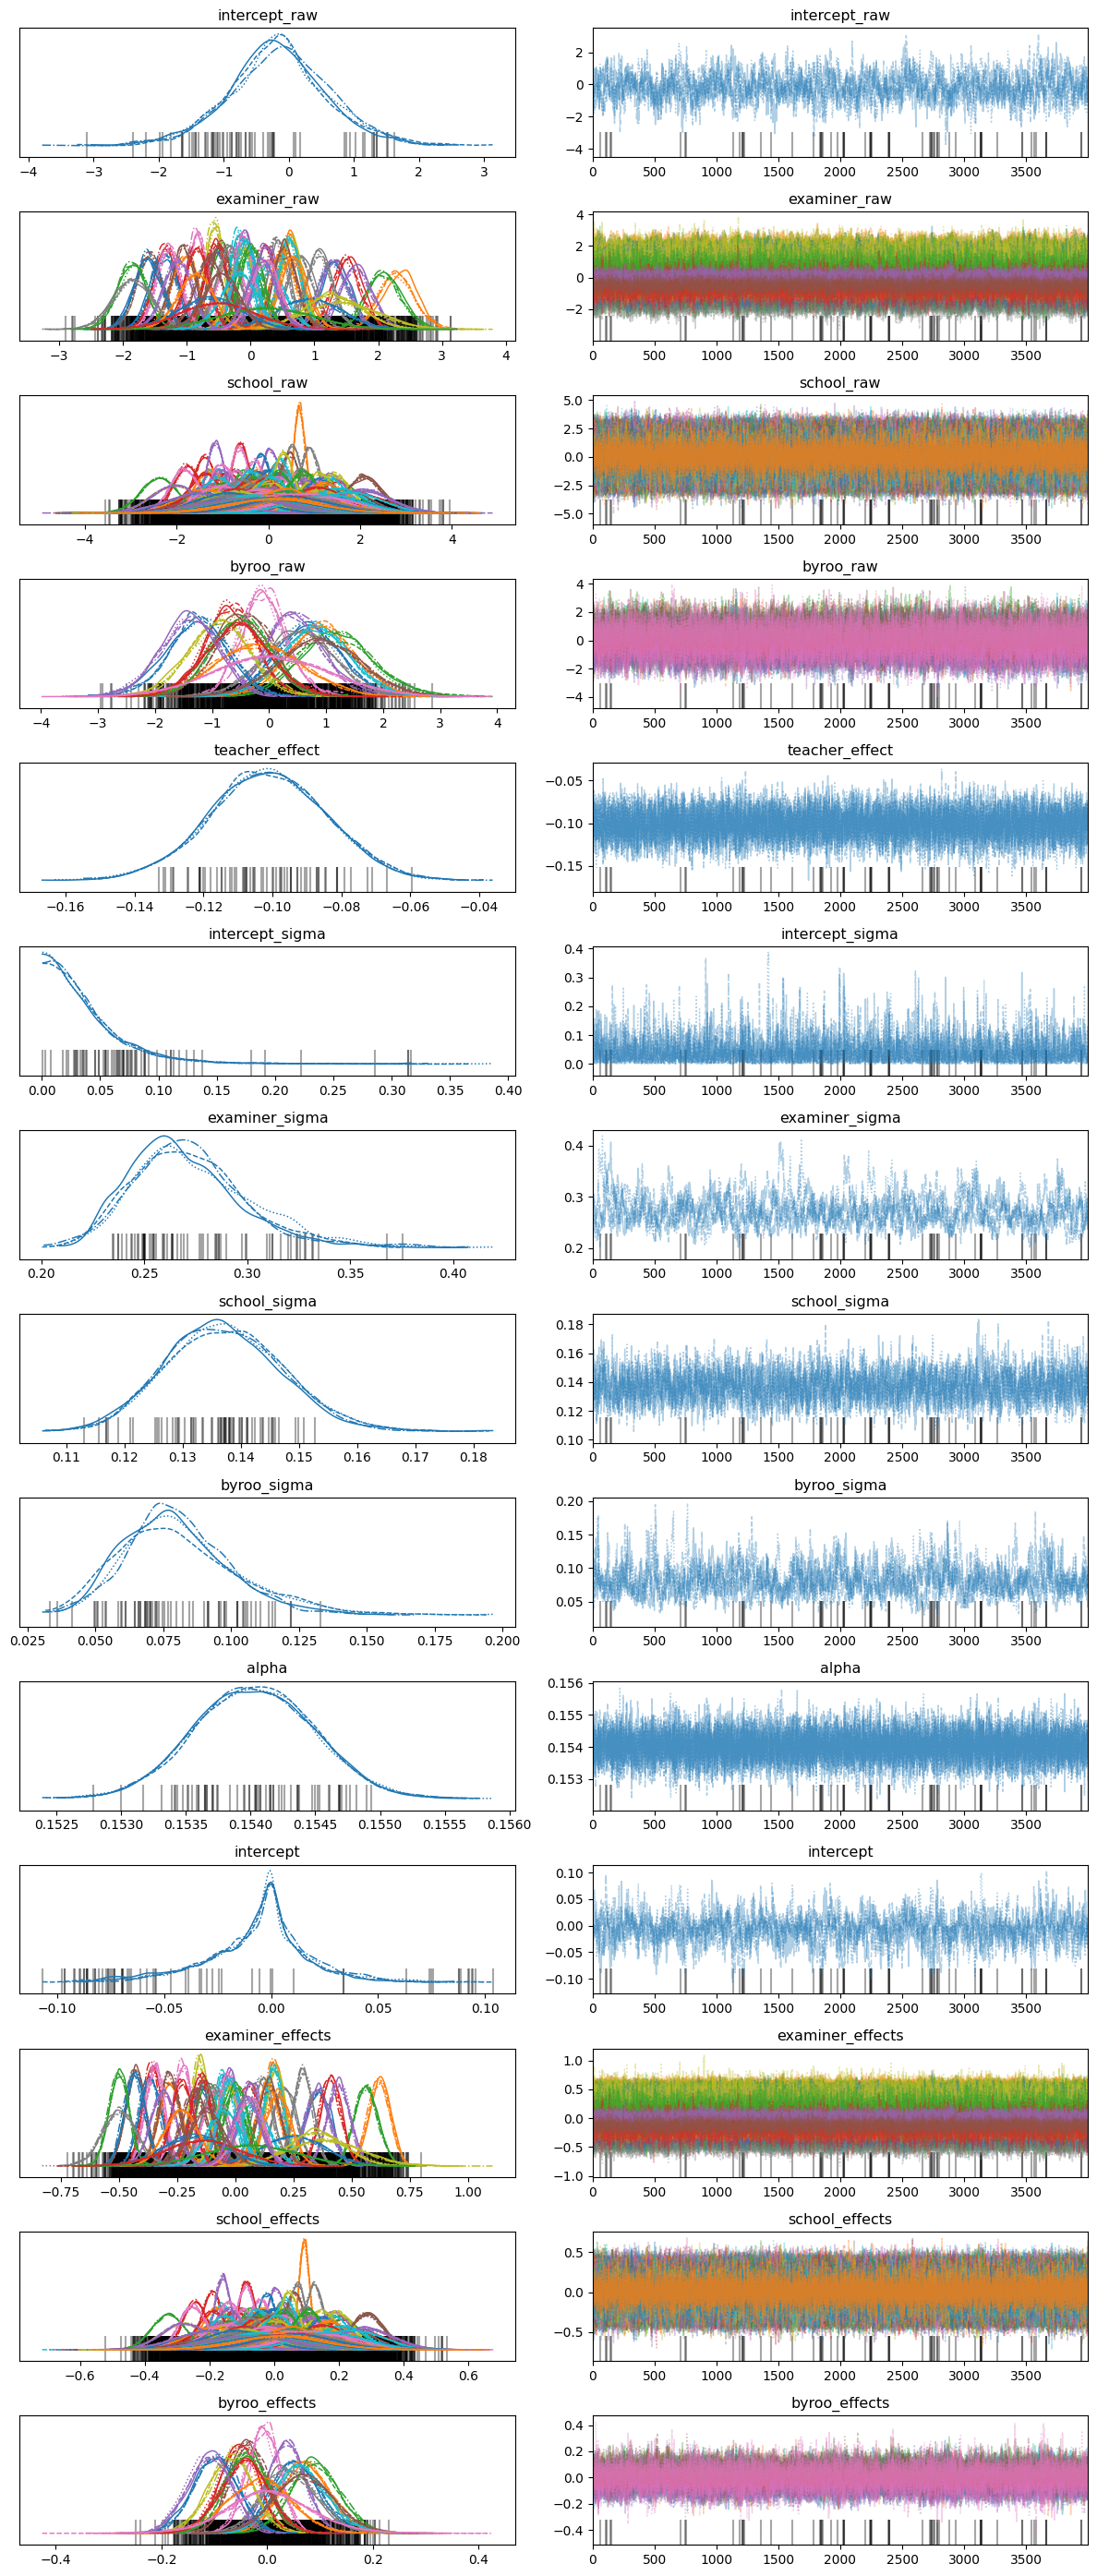

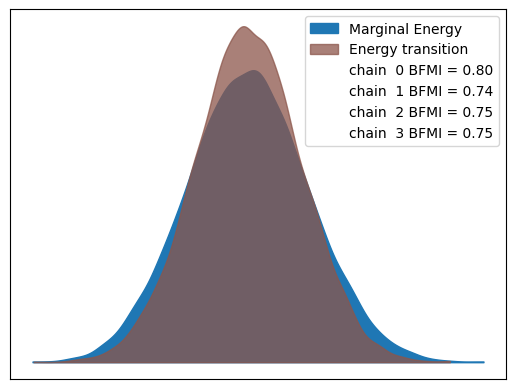


Number of divergent samples:
<xarray.DataArray 'diverging' ()> Size: 8B
array(68)


In [61]:
# Basic convergence diagnostics
print("\nModel Parameter Summary:")
summary = az.summary(trace, kind='diagnostics')

# Plot trace diagnostics
az.plot_trace(trace)
plt.tight_layout()
plt.show()

# Plot energy diagnostics
az.plot_energy(trace)
plt.show()

# Check for divergences
print("\nNumber of divergent samples:")
print(trace.sample_stats.diverging.sum())

In [62]:
df_summary[df_summary.r_hat>1.01]

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat


## Save trace

In [63]:
trace.to_netcdf("models/soidueksam_b_kat_multiyear_v4.nc")

'models/soidueksam_b_kat_multiyear_v4.nc'

## Load trace

In [42]:
trace = az.from_netcdf("models/soidueksam_b_kat_multiyear_v4.nc")

## overall exam success

In [43]:
def get_average_success_probability(trace):
    # Get intercept (baseline)
    intercept = trace.posterior['intercept'].values
    
    # Convert to probability using inverse logit
    baseline_prob = 1 / (1 + np.exp(-intercept))
    results = {
        'mean': np.mean(baseline_prob),
        'std': np.std(baseline_prob),
        'lower_ci': np.percentile(baseline_prob, 2.5),
        'upper_ci': np.percentile(baseline_prob, 97.5)
    }
    
    print("Overall Success Probability:")
    print(f"Mean: {results['mean']:.3f}")
    print(f"95% CI: [{results['lower_ci']:.3f}, {results['upper_ci']:.3f}]")
    
    return results

average_prob = get_average_success_probability(trace)
average_prob

Overall Success Probability:
Mean: 0.498
95% CI: [0.484, 0.511]


{'mean': 0.4984810433287717,
 'std': 0.006103428411138209,
 'lower_ci': 0.4844469203316007,
 'upper_ci': 0.5107338993907536}

In [44]:
df_b_sub.y.mean()

0.48168427091418353

## Factors that contribute the most

<Figure size 1800x500 with 0 Axes>

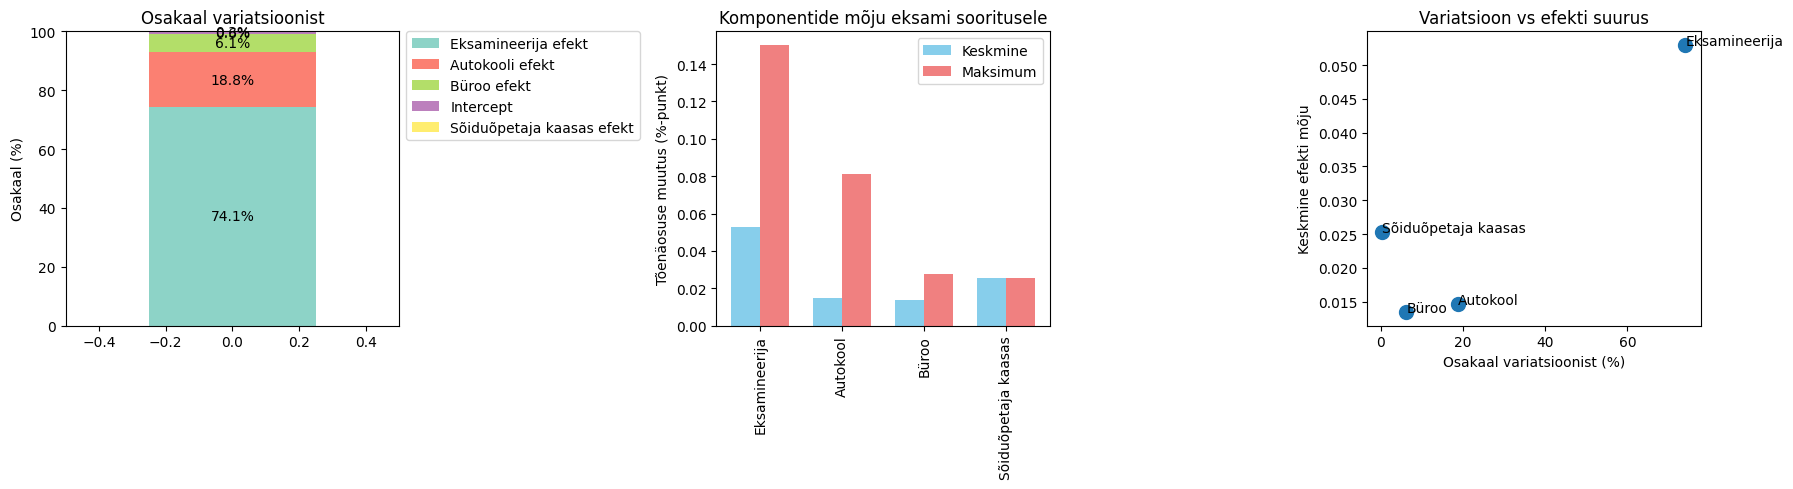

In [45]:
def analyze_component_contributions(trace):
    # Get components
    intercept_var = np.var(trace.posterior['intercept'].values)
    examiner_var = np.var(trace.posterior['examiner_effects'].values.reshape(-1))
    school_var = np.var(trace.posterior['school_effects'].values.reshape(-1))
    byroo_var = np.var(trace.posterior['byroo_effects'].values.reshape(-1))
    teacher_var = np.var(trace.posterior['teacher_effect'].values)
    
    # Calculate total variance
    total_var = (intercept_var + examiner_var + school_var + byroo_var + 
                 teacher_var )
    
    # Calculate proportions
    contributions = pd.Series({
        'Intercept': intercept_var/total_var,
        'Eksamineerija efekt': examiner_var/total_var,
        'Autokooli efekt': school_var/total_var,
        'Büroo efekt': byroo_var/total_var,
        'Sõiduõpetaja kaasas efekt': teacher_var/total_var,
    })
    
    return contributions * 100  # Convert to percentages

def logit_to_prob_change(effect):
    base_prob = 1 / (1 + np.exp(-0))  # 0.5
    new_prob = 1 / (1 + np.exp(-(0 + effect)))
    return new_prob - base_prob
    
    
def analyze_effect_sizes(trace, return_df=False):
    # Get absolute mean effects
    examiner_effects = np.abs(np.mean(trace.posterior['examiner_effects'].values, axis=(0,1)))
    school_effects = np.abs(np.mean(trace.posterior['school_effects'].values, axis=(0,1)))
    byroo_effects = np.abs(np.mean(trace.posterior['byroo_effects'].values, axis=(0,1)))
    teacher_effect = np.abs(np.mean(trace.posterior['teacher_effect'].values))

    result = {
        'Eksamineerija': {'mean': logit_to_prob_change(examiner_effects.mean()), 'max': logit_to_prob_change(examiner_effects.max())},
        'Autokool': {'mean': logit_to_prob_change(school_effects.mean()), 'max': logit_to_prob_change(school_effects.max())},
        'Büroo': {'mean': logit_to_prob_change(byroo_effects.mean()), 'max': logit_to_prob_change(byroo_effects.max())},
        'Sõiduõpetaja kaasas': {'mean': logit_to_prob_change(teacher_effect), 'max': logit_to_prob_change(teacher_effect)}
    }
    
    if return_df:
        return pd.DataFrame(result)
    return result

def plot_model_contributions(trace):
    # Get contributions
    contributions = analyze_component_contributions(trace)
    contributions=contributions.sort_values(ascending=False)
    
    
    # Create figure with more width for legend
    plt.figure(figsize=(18, 5))
    
    # Create figure with more width for legend
    plt.figure(figsize=(18, 5))
    
    # 1. Stacked Bar Plot
    plt.subplot(131)
    colors = plt.cm.Set3(np.linspace(0, 1, len(contributions)))
    
    # Create bars one by one to properly set up legend
    bottom = 0
    bars = []
    for i, (name, value) in enumerate(contributions.items()):
        bar = plt.bar(0, value, bottom=bottom, color=colors[i], width=0.5, label=name)
        plt.text(0, bottom + value/2, f'{value:.1f}%', ha='center', va='center')
        bottom += value
        bars.append(bar)
    
    plt.xlim(-0.5, 0.5)
    plt.ylim(0, 100)
    plt.ylabel('Osakaal (%)')
    plt.title('Osakaal variatsioonist')
    
    # Add legend
    plt.legend(bbox_to_anchor=(1.02, 1), 
              loc='upper left',
              borderaxespad=0)
    
    # 2. Bar Plot with Effect Sizes
    effect_sizes = analyze_effect_sizes(trace)
    plt.subplot(132)
    components = list(effect_sizes.keys())
    means = [d['mean'] for d in effect_sizes.values()]
    maxes = [d['max'] for d in effect_sizes.values()]
    
    x = np.arange(len(components))
    width = 0.35
    
    plt.bar(x - width/2, means, width, label='Keskmine', color='skyblue')
    plt.bar(x + width/2, maxes, width, label='Maksimum', color='lightcoral')
    plt.xticks(x, components, rotation=90)
    plt.title('Komponentide mõju eksami sooritusele')
    plt.ylabel('Tõenäosuse muutus (%-punkt)')
    plt.legend()
    
    # 3. Scatter Plot: Variance vs Mean Effect
    plt.subplot(133)
    # Map component names to contribution names
    name_map = {
        'Eksamineerija': 'Eksamineerija efekt',
        'Büroo': 'Büroo efekt',
        'Autokool': 'Autokooli efekt',
        'Month': 'Month Effects',
        'Sõiduõpetaja kaasas':'Sõiduõpetaja kaasas efekt',
        'Eri101':'Eri101'
        
    }
    matched_contributions = [contributions[name_map[c]] for c in components]
    
    plt.scatter(matched_contributions, means, s=100)
    for i, txt in enumerate(components):
        plt.annotate(txt, (matched_contributions[i], means[i]))
    plt.xlabel('Osakaal variatsioonist (%)')
    plt.ylabel('Keskmine efekti mõju')
    plt.title('Variatsioon vs efekti suurus')
    
    plt.tight_layout()
    plt.show()
    
plot_model_contributions(trace)

## Visualize effect contributions

In [46]:
df_b_sub.columns

Index(['KUUPAEV', 'BYROO', 'ERITINGIMUSED', 'VIIMANE_AUTOKOOL',
       'SOIDUOPETAJA_KAASAS', 'EKSAMINEERIJA', 'SEISUND', 'eri_101', 'eri_78',
       'eri_78_c', 'eri_96', 'y', 'y_transformed', 'EKSAMINEERIJA_CLEAN',
       'examiner_idx', 'school_idx', 'passed', 'byroo_idx', 'teacher_present',
       'teacher_present_c'],
      dtype='object')

In [47]:
df_b_sub=df_b_sub.reset_index(drop=True)


Probability changes:
Intercept: -0.002
Eksamineerija: 0.088
Autokool: -0.002
Büroo: 0.013
Sõiduõpetaja: 0.002

Final probability: 0.599
Actual outcome: 0.000


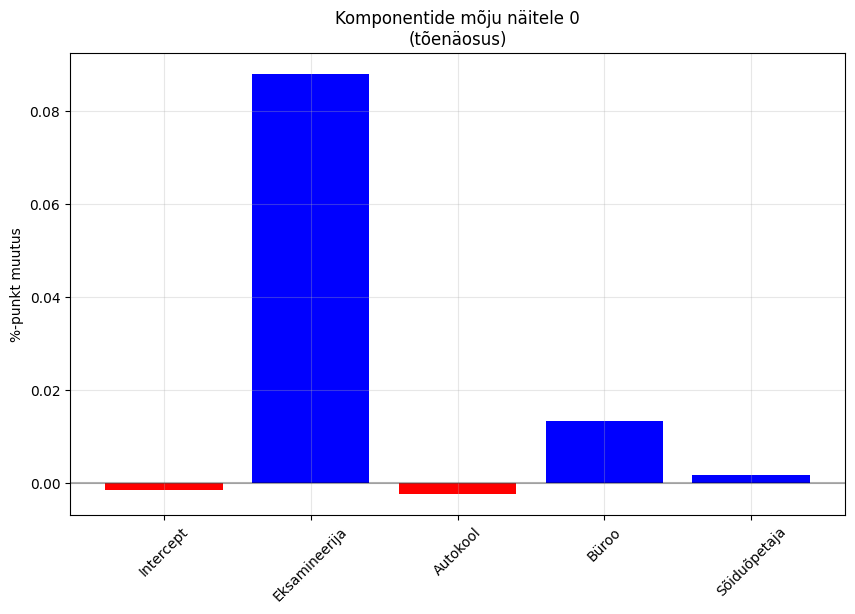

In [48]:
# Get posterior means
examiner_effects_mean = trace.posterior['examiner_effects'].mean(dim=('chain', 'draw'))
school_effects_mean = trace.posterior['school_effects'].mean(dim=('chain', 'draw'))
byroo_effects_mean = trace.posterior['byroo_effects'].mean(dim=('chain', 'draw'))
teacher_effect_mean = trace.posterior['teacher_effect'].mean(dim=('chain', 'draw'))
intercept_effect_mean = float(trace.posterior['intercept'].mean())

def plot_effects_breakdown_prob(sample_idx):
    # Get base effects (logit scale)
    effects = {
        'Intercept': intercept_effect_mean,
        'Eksamineerija': examiner_effects_mean[df_b_sub['examiner_idx'].iloc[sample_idx]],
        'Autokool': school_effects_mean[df_b_sub['school_idx'].iloc[sample_idx]],
        'Büroo': byroo_effects_mean[df_b_sub['byroo_idx'].iloc[sample_idx]],
        'Sõiduõpetaja' : teacher_effect_mean*df_b_sub['teacher_present_c'].iloc[sample_idx]
    }
    
    # Convert to probability changes
    prob_changes = {}
    cumulative = 0
    for k, v in effects.items():
        prev_prob = sp.expit(cumulative)
        cumulative += v
        new_prob = sp.expit(cumulative)
        prob_changes[k] = new_prob - prev_prob
    
    # Plot
    plt.figure(figsize=(10, 6))
    colors = ['blue' if v >= 0 else 'red' for v in prob_changes.values()]
    plt.bar(prob_changes.keys(), prob_changes.values(), color=colors)
    plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    plt.title(f'Komponentide mõju näitele {sample_idx}\n(tõenäosus)')
    plt.ylabel('%-punkt muutus')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    
    # Print values
    print("\nProbability changes:")
    for k, v in prob_changes.items():
        print(f"{k}: {v:.3f}")
    print(f"\nFinal probability: {sp.expit(sum(effects.values())):.3f}")
    print(f"Actual outcome: {df_b_sub['y_transformed'].iloc[sample_idx]:.3f}")
    
plot_effects_breakdown_prob(0)


Probability changes:
Intercept: -0.002
Eksamineerija: 0.150
Autokool: 0.021
Büroo: 0.016
Sõiduõpetaja: 0.002

Final probability: 0.687
Actual outcome: 1.000


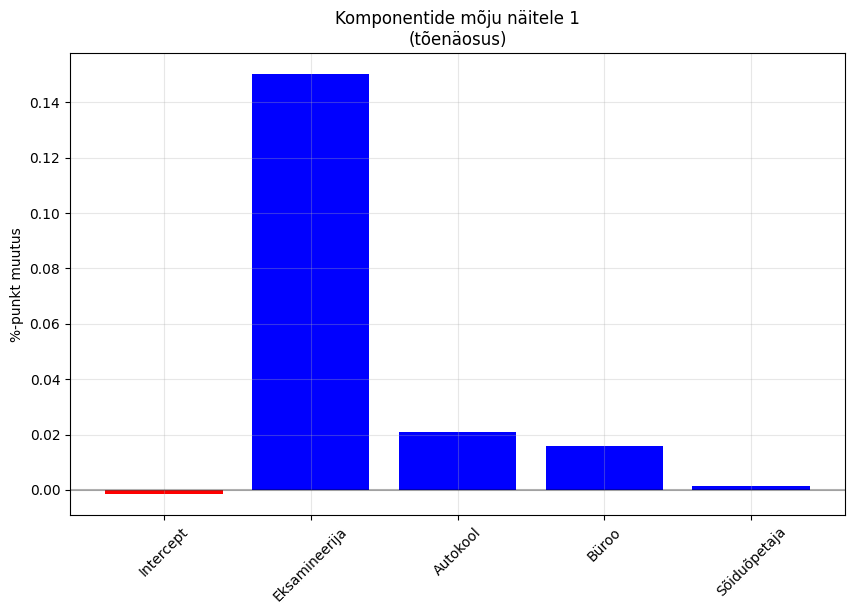

In [49]:
plot_effects_breakdown_prob(1)


Probability changes:
Intercept: -0.002
Eksamineerija: 0.042
Autokool: -0.022
Büroo: -0.002
Sõiduõpetaja: 0.002

Final probability: 0.518
Actual outcome: 1.000


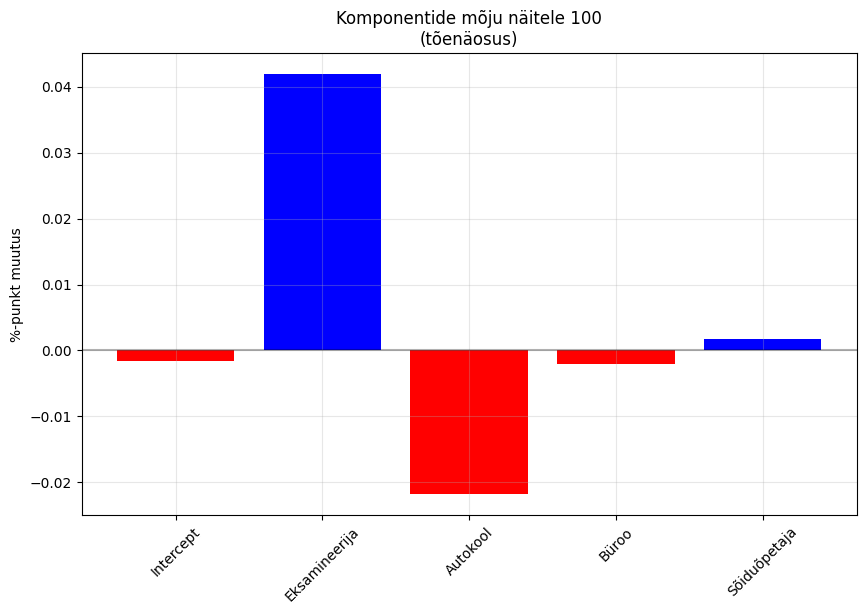

In [50]:
plot_effects_breakdown_prob(100)

## Examiner effects

In [136]:
examiner_bureau_max = pd.DataFrame(df_b_sub.groupby(['EKSAMINEERIJA'])['BYROO']
                      .value_counts()
                      .groupby(level=0)  # Group by examiner
                      .nlargest(1))    # Get largest count for each examiner
examiner_bureau_max.unstack()

count                                  \
BYROO                             Tallinn Rakvere   Pärnu   Tartu   Narva   
EKSAMINEERIJA    EKSAMINEERIJA                                              
00fe4a180f5c474e 00fe4a180f5c474e    17.0     NaN     NaN     NaN     NaN   
01be6f2aa5cba2cd 01be6f2aa5cba2cd   655.0     NaN     NaN     NaN     NaN   
075e15cf091d347b 075e15cf091d347b     NaN  2443.0     NaN     NaN     NaN   
0f8b5f7ee00be8ae 0f8b5f7ee00be8ae  1275.0     NaN     NaN     NaN     NaN   
12ed0758e403a7d6 12ed0758e403a7d6     NaN     NaN  2481.0     NaN     NaN   
138291a4de4e3243 138291a4de4e3243     NaN     NaN     NaN     3.0     NaN   
147b5bf6bba0d0f1 147b5bf6bba0d0f1     NaN  1897.0     NaN     NaN     NaN   
166c8268fe1b2ec1 166c8268fe1b2ec1     NaN     NaN     NaN     NaN  3101.0   
16ff08c229c6ea58 16ff08c229c6ea58   389.0     NaN     NaN     NaN     NaN   
213d8a3fa533a2ce 213d8a3fa533a2ce     NaN     NaN     NaN     NaN     NaN   
22b4bbeee5e023b3 22b4bbeee5e023b3    90.0     NaN     NaN     NaN     NaN   
268b141c418a500d 268b141c418a500d     NaN     NaN     NaN     NaN     NaN   
296771b1cd7d241d 296771b1cd7d241d     NaN     NaN     NaN     NaN     NaN   
2bf951502cbf7e6b 2bf951502cbf7e6b  2341.0     NaN     NaN     NaN     NaN   
31451a368e962058 31451a368e962058     NaN     NaN     NaN     NaN     NaN   
32a030820e9d4091 32a030820e9d4091     NaN  1922.0     NaN     NaN     NaN   
3d6f4cd3cca10b28 3d6f4cd3cca10b28  2873.0     NaN     NaN     NaN     NaN   
400e86ed874ccd07 400e86ed874ccd07  2037.0     NaN     NaN     NaN     NaN   
40bcf2cea820fca6 40bcf2cea820fca6     NaN     NaN     NaN   341.0     NaN   
4141299ff500eb11 4141299ff500eb11     NaN  2283.0     NaN     NaN     NaN   
48ff838b9412535e 48ff838b9412535e     NaN     NaN     NaN     NaN     NaN   
4b9e369e12d8f969 4b9e369e12d8f969  2419.0     NaN     NaN     NaN     NaN   
4ee4a4702131dac3 4ee4a4702131dac3  2084.0     NaN     NaN     NaN     NaN   
4fb83c2d4f79eb33 4fb83c2d4f79eb33     NaN     NaN     NaN   413.0     NaN   
5c9ee299be483144 5c9ee299be483144  2159.0     NaN     NaN     NaN     NaN   
5f2e29794998d365 5f2e29794998d365     NaN     NaN     NaN   913.0     NaN   
602d00a56a9a8757 602d00a56a9a8757     NaN     NaN     NaN     NaN     NaN   
60a711f0057108eb 60a711f0057108eb     NaN     NaN     NaN     NaN     NaN   
844452b4e4bac2ef 844452b4e4bac2ef     NaN     NaN     NaN  2195.0     NaN   
9b4f58581a3135a7 9b4f58581a3135a7     NaN     NaN     4.0     NaN     NaN   
9f3e3d07ecb6a86c 9f3e3d07ecb6a86c  2460.0     NaN     NaN     NaN     NaN   
a1d9e404aeec83d1 a1d9e404aeec83d1  3475.0     NaN     NaN     NaN     NaN   
a37826c7bbe98142 a37826c7bbe98142     NaN     NaN     NaN     NaN     NaN   
a90a6cc35a006268 a90a6cc35a006268     NaN     NaN     NaN     NaN     NaN   
ae264be409f2ca9f ae264be409f2ca9f     NaN     NaN     NaN  2285.0     NaN   
b2c5041e3a3cfff4 b2c5041e3a3cfff4     NaN     NaN     NaN     NaN     NaN   
b353c311e671711a b353c311e671711a  2892.0     NaN     NaN     NaN     NaN   
b3e368548c216eb8 b3e368548c216eb8  1270.0     NaN     NaN     NaN     NaN   
b6982cbd7a6000e4 b6982cbd7a6000e4  4397.0     NaN     NaN     NaN     NaN   
b7576201d47b425b b7576201d47b425b   839.0     NaN     NaN     NaN     NaN   
b89f5e763b05e7a7 b89f5e763b05e7a7     NaN     NaN     NaN  1411.0     NaN   
baa43a4ad02e3a60 baa43a4ad02e3a60  1275.0     NaN     NaN     NaN     NaN   
be39b89bc70a335e be39b89bc70a335e  2503.0     NaN     NaN     NaN     NaN   
bf2b7218d36e2a3d bf2b7218d36e2a3d     NaN     NaN     NaN     NaN     NaN   
c347692cf48342d6 c347692cf48342d6     NaN     NaN  2142.0     NaN     NaN   
c6d0f1ea0c1f7aec c6d0f1ea0c1f7aec  4208.0     NaN     NaN     NaN     NaN   
c74b0de43bcd0b0f c74b0de43bcd0b0f     NaN     NaN     NaN     NaN     NaN   
cee792f71833b03b cee792f71833b03b     NaN     NaN     NaN  1119.0     NaN   
d15d81b55baf64ed d15d81b55baf64ed  1714.0     NaN     NaN     NaN     NaN   
d321254aa86edd96 d321254aa86edd9

In [137]:
examiner_bureau_max=examiner_bureau_max.reset_index(level=0) 
examiner_bureau_max.head()

,,EKSAMINEERIJA,count
EKSAMINEERIJA,BYROO,,
00fe4a180f5c474e,Tallinn,00fe4a180f5c474e,17
01be6f2aa5cba2cd,Tallinn,01be6f2aa5cba2cd,655
075e15cf091d347b,Rakvere,075e15cf091d347b,2443
0f8b5f7ee00be8ae,Tallinn,0f8b5f7ee00be8ae,1275
12ed0758e403a7d6,Pärnu,12ed0758e403a7d6,2481


Number of examiner_idx with significant positive effect: 17
Number of examiner_idx with significant negative effect: 19


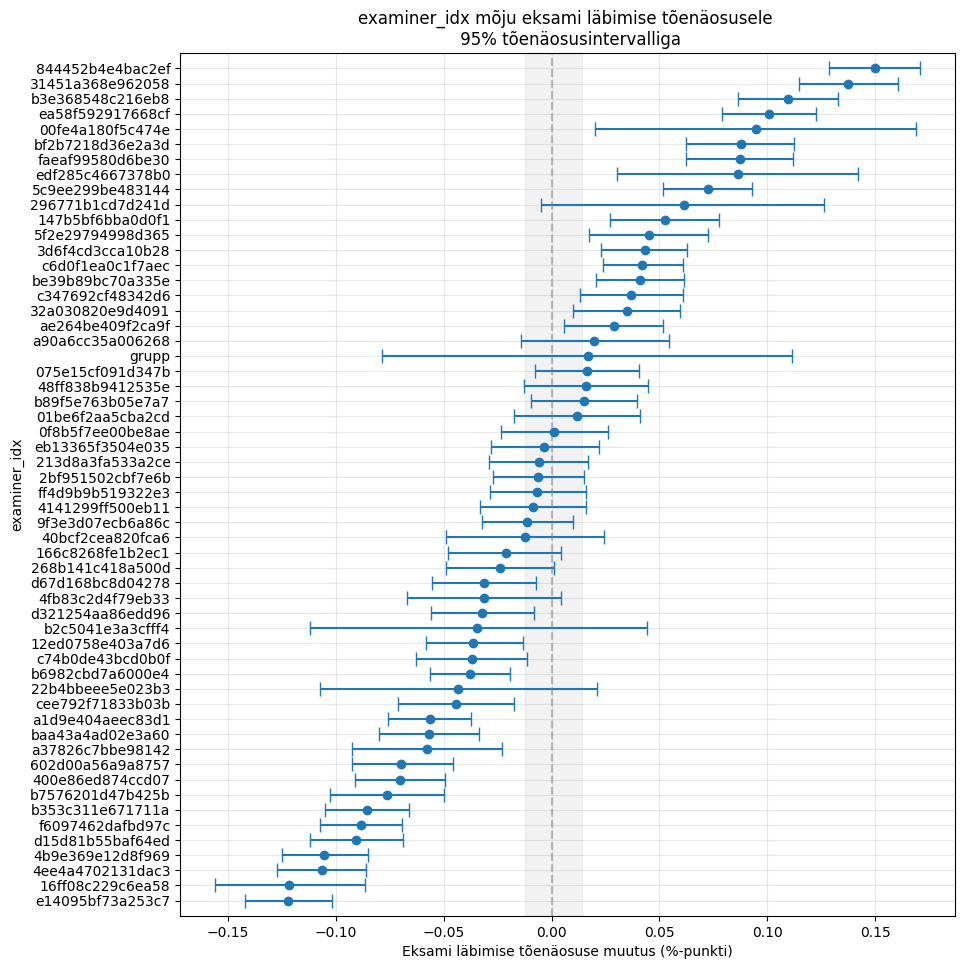

In [138]:
def plot_effects(y_labels_col='examiner_idx', effects_key='examiner_effects', only_significant=False,
                y_dict=None, return_data=False):
# Get all samples for examiner effects
    examiner_samples = trace.posterior[effects_key]
    
    # Get examiner IDs (assuming they're in the original order in df_b_sub)
    examiner_ids = df_b_sub[y_labels_col].unique()
    
    # Calculate mean and HDI for each examiner
    means = []
    hdis = []
    ids = []  # Store IDs in same order as effects
    labels=[]
    
    # Convert logit effects to probability changes
    base_prob = sp.expit(intercept_effect_mean)
    
    for i in range(examiner_samples.shape[2]):
        effect_samples = examiner_samples[:, :, i].values.flatten()
        prob_changes = sp.expit(intercept_effect_mean + effect_samples) - base_prob
        percentiles=np.percentile(prob_changes, [2.5, 97.5])
        if only_significant and ((percentiles[0]<0.0 and percentiles[1]<0.0) or (percentiles[0]>0.0 and percentiles[1]>0.0)):
            means.append(np.mean(prob_changes))
            hdis.append(percentiles)
            ids.append(examiner_ids[i])
            if y_dict is not None:
                labels.append(y_dict[examiner_ids[i]])
        elif not only_significant:
            means.append(np.mean(prob_changes))
            hdis.append(percentiles)
            ids.append(examiner_ids[i])
            if y_dict is not None:
                labels.append(y_dict[examiner_ids[i]])
    
    # Sort by mean effect
    sorted_indices = np.argsort(means)
    means = np.array(means)[sorted_indices]
    hdis = np.array(hdis)[sorted_indices]
    ids = np.array(ids)[sorted_indices]
    if len(labels)>0:
        labels = np.array(labels)[sorted_indices]
    
    # Calculate confidence interval for baseline probability
    intercept_samples = trace.posterior['intercept'].values.flatten()
    base_probs = sp.expit(intercept_samples)
    base_ci = np.percentile(base_probs, [2.5, 97.5])
    
    # Plot
    plt.figure(figsize=(10, len(means)*0.2))
    
    # Add shaded confidence interval around zero
    plt.axvspan(-base_ci[1] + base_prob, -base_ci[0] + base_prob, 
                color='grey', alpha=0.1, label='Baseline CI')
    
    # Plot effects
    plt.errorbar(means, range(len(means)),
                xerr=[means - hdis[:, 0], hdis[:, 1] - means],
                fmt='o', capsize=5)
    plt.axvline(x=0, color='grey', linestyle='--', alpha=0.5)
       
    # Add examiner IDs to y-axis
    if y_dict is not None:
        plt.yticks(range(len(means)), labels)
    else:
        plt.yticks(range(len(means)), ids)
     # Adjust y-axis limits to remove extra margins
    plt.ylim(-1.0, len(means))  # This removes the extra space
    
    plt.ylabel(y_labels_col)
    plt.xlabel('Eksami läbimise tõenäosuse muutus (%-punkti)')
    plt.title(f'{y_labels_col} mõju eksami läbimise tõenäosusele \n 95% tõenäosusintervalliga')
    plt.grid(True, alpha=0.3)
    
    # Print summary statistics
    print(f"Number of {y_labels_col} with significant positive effect: {sum(hdis[:, 0] > 0)}")
    print(f"Number of {y_labels_col} with significant negative effect: {sum(hdis[:, 1] < 0)}")
    if return_data:
        df=pd.DataFrame(hdis)
        df.columns=['low', 'high']
        df['mean']=means
        df['id']=ids
        if len(labels)>0:
            df['label']=labels
        return df
    
def plot_effects(y_labels_col='examiner_idx', effects_key='examiner_effects', only_significant=False,
                y_dict=None, return_data=False):
# Get all samples for examiner effects
    examiner_samples = trace.posterior[effects_key]
    
    # Get examiner IDs (assuming they're in the original order in df_b_sub)
    examiner_ids = df_b_sub[y_labels_col].unique()
    
    # Calculate mean and HDI for each examiner
    means = []
    hdis = []
    ids = []  # Store IDs in same order as effects
    labels=[]
    
     # Convert logit effects to probability changes
    base_prob = sp.expit(intercept_effect_mean)
    # Calculate baseline CI once
    intercept_samples = trace.posterior['intercept'].values.flatten()
    base_probs = sp.expit(intercept_samples)
    base_ci = np.percentile(base_probs, [2.5, 97.5])
    
    for i in range(examiner_samples.shape[2]):
        effect_samples = examiner_samples[:, :, i].values.flatten()
        prob_changes = sp.expit(intercept_effect_mean + effect_samples) - base_prob
        percentiles = np.percentile(prob_changes, [2.5, 97.5])
        
        # Check for significance considering baseline CI overlap
        is_significant = False
        if percentiles[1] < -base_ci[1] + base_prob:  # Significantly negative
            is_significant = True
        elif percentiles[0] > -base_ci[0] + base_prob:  # Significantly positive
            is_significant = True
            
        if only_significant and is_significant:
            means.append(np.mean(prob_changes))
            hdis.append(percentiles)
            ids.append(examiner_ids[i])
            if y_dict is not None:
                labels.append(y_dict[examiner_ids[i]])
        elif not only_significant:
            means.append(np.mean(prob_changes))
            hdis.append(percentiles)
            ids.append(examiner_ids[i])
            if y_dict is not None:
                labels.append(y_dict[examiner_ids[i]])
    
    # Sort by mean effect
    sorted_indices = np.argsort(means)
    means = np.array(means)[sorted_indices]
    hdis = np.array(hdis)[sorted_indices]
    ids = np.array(ids)[sorted_indices]
    if len(labels)>0:
        labels = np.array(labels)[sorted_indices]
    
    # Calculate confidence interval for baseline probability
    intercept_samples = trace.posterior['intercept'].values.flatten()
    base_probs = sp.expit(intercept_samples)
    base_ci = np.percentile(base_probs, [2.5, 97.5])
    
    # Plot
    plt.figure(figsize=(10, len(means)*0.2))
    
    # Add shaded confidence interval around zero
    plt.axvspan(-base_ci[1] + base_prob, -base_ci[0] + base_prob, 
                color='grey', alpha=0.1, label='Baseline CI')
    
    # Plot effects
    plt.errorbar(means, range(len(means)),
                xerr=[means - hdis[:, 0], hdis[:, 1] - means],
                fmt='o', capsize=5)
    plt.axvline(x=0, color='grey', linestyle='--', alpha=0.5)
       
    if y_dict is not None:
        plt.yticks(range(len(means)), labels)
    else:
        plt.yticks(range(len(means)), ids)
    plt.ylim(-1.0, len(means))  # This removes the extra space
    
    plt.ylabel(y_labels_col)
    plt.xlabel('Eksami läbimise tõenäosuse muutus (%-punkti)')
    plt.title(f'{y_labels_col} mõju eksami läbimise tõenäosusele \n 95% tõenäosusintervalliga')
    plt.grid(True, alpha=0.3)
    
    # Print summary statistics
    print(f"Number of {y_labels_col} with significant positive effect: {sum(hdis[:, 0] > 0)}")
    print(f"Number of {y_labels_col} with significant negative effect: {sum(hdis[:, 1] < 0)}")
    if return_data:
        df=pd.DataFrame(hdis)
        df.columns=['low', 'high']
        df['mean']=means
        df['id']=ids
        if len(labels)>0:
            df['label']=labels
        return df
    
df_examiner=plot_effects(y_dict=idx_to_examiner, return_data=True)

Number of examiner_idx with significant positive effect: 14
Number of examiner_idx with significant negative effect: 16


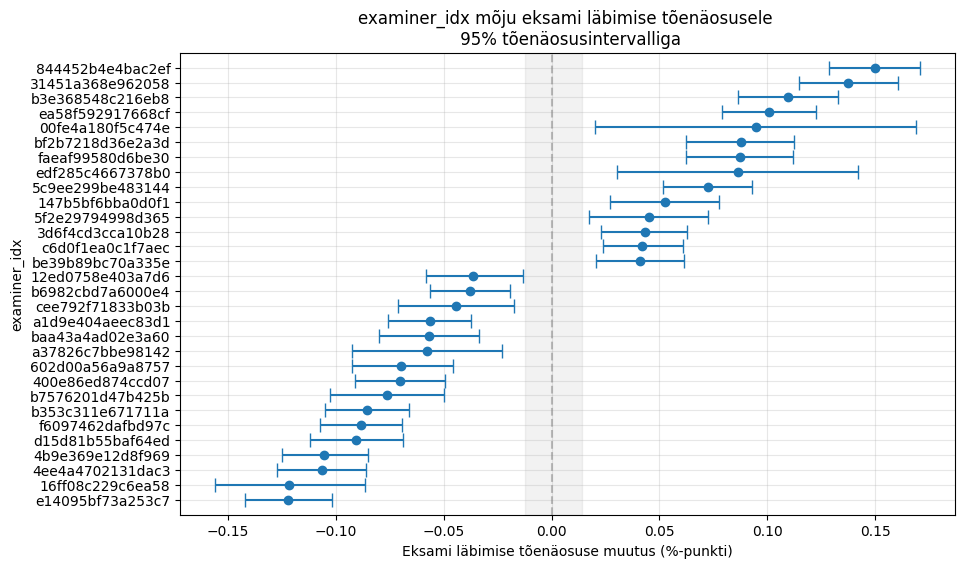

In [139]:
plot_effects(y_dict=idx_to_examiner, only_significant=True, return_data=False)

In [140]:
df_examiner_count=pd.DataFrame(df_b_sub['EKSAMINEERIJA'].value_counts())
df_examiner_count.shape

(58, 1)

In [141]:
df_examiner=df_examiner.merge(df_examiner_count, left_on='label', right_index=True, how='left')
df_examiner=df_examiner.merge(examiner_bureau_max[['count']].reset_index(),  left_on='label', right_on='EKSAMINEERIJA', how='left')
df_examiner.shape

(56, 9)

<Axes: xlabel='mean', ylabel='count_x'>

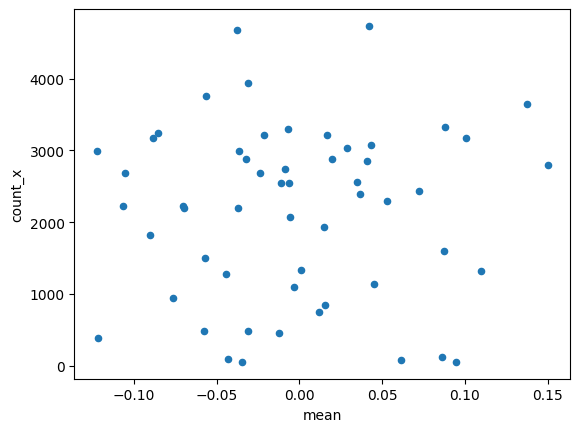

In [142]:
#number of exams vs mean effect
df_examiner.plot.scatter('mean', 'count_x')

/tmp/ipykernel_86/3790301084.py:9: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(df_examiner[mask]['mean'],


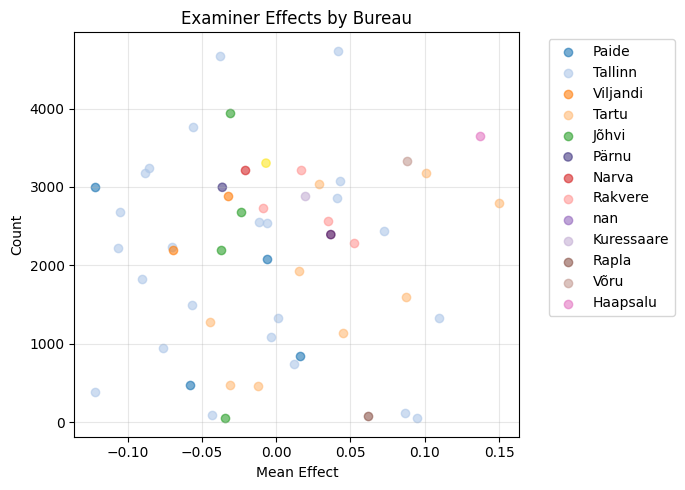

In [154]:
# Create color mapping for BYROO
unique_byroos = df_examiner['BYROO'].unique()
color_map = dict(zip(unique_byroos, plt.cm.tab20.colors[:len(unique_byroos)]))

# Create the plot
plt.figure(figsize=(7, 5))
for byroo in unique_byroos:
    mask = df_examiner['BYROO'] == byroo
    plt.scatter(df_examiner[mask]['mean'], 
               df_examiner[mask]['count_x'],
               label=byroo,
               c=color_map[byroo],
               alpha=0.6)

plt.xlabel('Mean Effect')
plt.ylabel('Count')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('Examiner Effects by Bureau')
plt.grid(True, alpha=0.3)
plt.tight_layout()

## School effects

In [158]:
df_b_sub.VIIMANE_AUTOKOOL.str.lower().nunique()

352

Number of school_idx with significant positive effect: 14
Number of school_idx with significant negative effect: 12


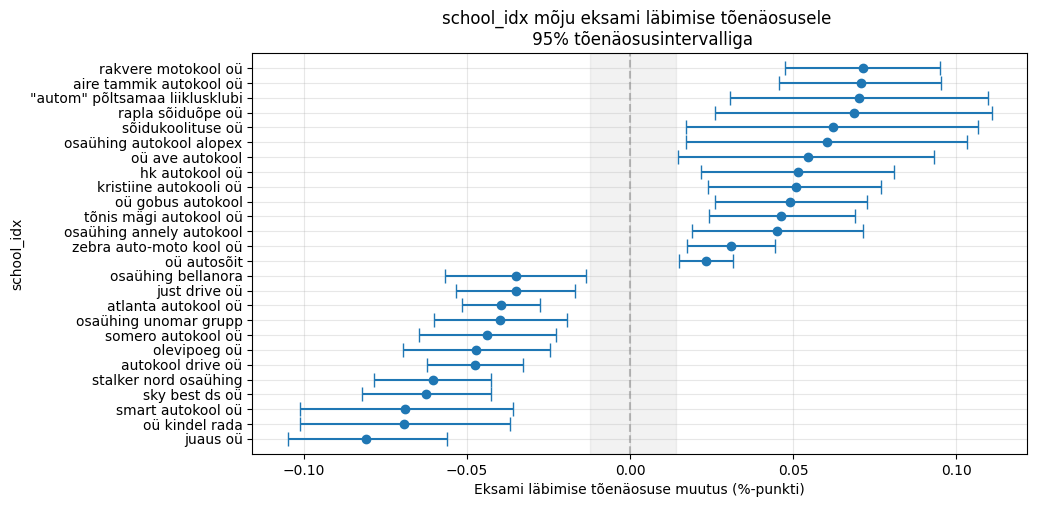

In [160]:
df_school=plot_effects(y_labels_col='school_idx', effects_key='school_effects', only_significant=True,
             y_dict=idx_to_school, return_data=True)

In [65]:
df_b_sub[df_b_sub.VIIMANE_AUTOKOOL.str.contains('just drive oü',case=False)].y.mean()

0.38072122052704577

In [66]:
df_b_sub[df_b_sub.VIIMANE_AUTOKOOL.str.contains('somero',case=False)].y.mean()

0.36852394916911047

In [163]:
df_school.sort_values('mean')

,low,high,mean,id,label
0,-0.104968,-0.056230,-0.080804,72,juaus oü
1,-0.101285,-0.036726,-0.069345,134,oü kindel rada
2,-0.101179,-0.035728,-0.068894,28,smart autokool oü
3,-0.082108,-0.042681,-0.062393,116,sky best ds oü
4,-0.078548,-0.042468,-0.060404,33,stalker nord osaühing
5,-0.062281,-0.032664,-0.047599,3,autokool drive oü
6,-0.069510,-0.024457,-0.047125,73,olevipoeg oü
7,-0.064708,-0.022792,-0.043968,41,somero autokool oü
8,-0.059977,-0.019258,-0.039844,9,osaühing unomar grupp
9,-0.051370,-0.027624,-0.039542,54,atlanta autokool oü


## Büroo effects

Number of byroo_idx with significant positive effect: 1
Number of byroo_idx with significant negative effect: 2


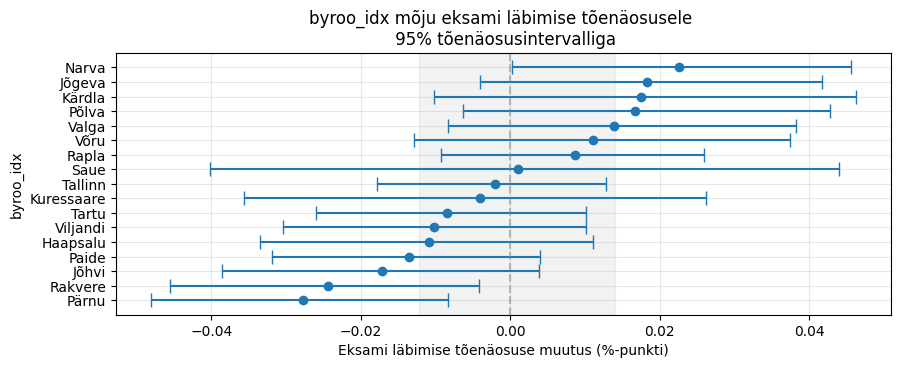

In [164]:
plot_effects(y_labels_col='byroo_idx', effects_key='byroo_effects', only_significant=False,
             y_dict=idx_to_byroo)

## Teacher present

In [167]:
def plot_binary_effects(binary_effects=['teacher_effect'],
                       effect_labels=['Sõiduõpetaja kaasas']):
    # Calculate mean and HDI for each binary effect
    means = []
    hdis = []
    
    # Convert logit effects to probability changes
    base_prob = sp.expit(intercept_effect_mean)
    
    for effect_name in binary_effects:
        effect_samples = trace.posterior[effect_name].values.flatten()
        prob_changes = sp.expit(intercept_effect_mean + effect_samples) - base_prob
        
        means.append(np.mean(prob_changes))
        hdis.append(np.percentile(prob_changes, [2.5, 97.5]))
    
    # Convert to arrays
    means = np.array(means)
    hdis = np.array(hdis)
    
    # Calculate confidence interval for baseline probability
    intercept_samples = trace.posterior['intercept'].values.flatten()
    base_probs = sp.expit(intercept_samples)
    base_ci = np.percentile(base_probs, [2.5, 97.5])
    
    # Plot
    plt.figure(figsize=(10, len(means)*0.5))
    
    # Add shaded confidence interval around zero
    plt.axvspan(-base_ci[1] + base_prob, -base_ci[0] + base_prob, 
                color='grey', alpha=0.1, label='Baseline CI')
    
    # Plot effects
    plt.errorbar(means, range(len(means)),
                xerr=[means - hdis[:, 0], hdis[:, 1] - means],
                fmt='o', capsize=5, markersize=10)
    plt.axvline(x=0, color='grey', linestyle='--', alpha=0.5)
    
    # Add effect labels
    plt.yticks(range(len(means)), effect_labels)
    plt.ylim(-0.5, len(means)-0.5)
    
    # plt.ylabel('Binary Effects')
    plt.xlabel('Eksami läbimise tõenäosuse muutus (%-punkti)')
    plt.title('mõju eksami läbimise tõenäosusele \n 95% tõenäosusintervalliga')
    plt.grid(True, alpha=0.3)
    
    # Print summary statistics
    print("Significant effects:")
    for label, hdi in zip(effect_labels, hdis):
        if hdi[0] > 0:
            print(f"{label}: Significant positive effect")
        elif hdi[1] < 0:
            print(f"{label}: Significant negative effect")
        else:
            print(f"{label}: No significant effect")

Significant effects:
Sõiduõpetaja kaasas: Significant negative effect


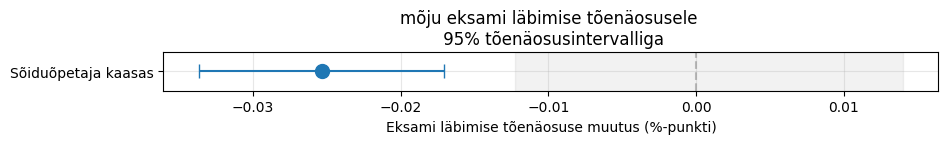

In [168]:
plot_binary_effects()

## Predict on training data to get estimate on accuracy

In [70]:
# Get posterior means
examiner_effects_mean = trace.posterior['examiner_effects'].mean(dim=('chain', 'draw'))
school_effects_mean = trace.posterior['school_effects'].mean(dim=('chain', 'draw'))
byroo_effects_mean = trace.posterior['byroo_effects'].mean(dim=('chain', 'draw'))
teacher_effect_mean = trace.posterior['teacher_effect'].mean(dim=('chain', 'draw'))
intercept_effect_mean = float(trace.posterior['intercept'].mean())

def effects_breakdown_prob(sample_idx):
    # Get base effects (logit scale)
    effects = {
        'Intercept': intercept_effect_mean,
        'Examiner': examiner_effects_mean[df_b_sub['examiner_idx'].iloc[sample_idx]],
        'School': school_effects_mean[df_b_sub['school_idx'].iloc[sample_idx]],
        'Bureau': byroo_effects_mean[df_b_sub['byroo_idx'].iloc[sample_idx]],
        'Teacher' : teacher_effect_mean*df_b_sub['teacher_present_c'].iloc[sample_idx]
    }
    
    # Convert to probability changes
    prob_changes = {}
    cumulative = 0
    for k, v in effects.items():
        prev_prob = sp.expit(cumulative)
        cumulative += v
        new_prob = sp.expit(cumulative)
        res= (new_prob - prev_prob)
        if k=='Intercept':
            prob_changes[k] = res#[0]
        else:
            prob_changes[k] = float(res.data)#[0]
            
    
    return prob_changes


In [71]:
preds=[]
for i in range(df_b_sub.shape[0]):
    res_=effects_breakdown_prob(i)
    preds.append(res_)

In [72]:
df_b_sub['pred_raw']=preds
df_b_sub['pred_sum']=df_b_sub['pred_raw'].apply(lambda x: np.sum(list(x.values())))
df_b_sub['pred']=np.where(df_b_sub['pred_sum']>0., 1, 0)

In [73]:
np.sum(list(res_.values()))

-0.06945380935659834

In [74]:
print(classification_report(df_b_sub.y, df_b_sub.pred))

              precision    recall  f1-score   support

         0.0       0.62      0.70      0.66     61437
         1.0       0.63      0.54      0.58     57095

    accuracy                           0.62    118532
   macro avg       0.62      0.62      0.62    118532
weighted avg       0.62      0.62      0.62    118532



## individual max effects

In [81]:
pd.DataFrame(df_b_sub.pred_raw.tolist())

,Intercept,Examiner,School,Bureau,Teacher
0,-0.001519,0.088016,-0.002395,0.013410,0.001683
1,-0.001519,0.150211,0.020905,0.015995,0.001507
2,-0.001519,-0.031173,-0.015619,0.022551,0.001746
3,-0.001519,0.088016,-0.002395,0.013410,-0.022867
4,-0.001519,-0.088238,-0.045315,-0.012505,0.001600
...,...,...,...,...,...
118527,-0.001519,-0.056830,0.023059,-0.002091,0.001741
118528,-0.001519,-0.056830,0.017811,-0.002087,-0.023288
118529,-0.001519,-0.008621,-0.035036,-0.024138,0.001718
118530,-0.001519,-0.008621,-0.010862,-0.024351,0.001736


## Save model data

In [51]:
def clean_name_for_js(name):
    """Clean names for JavaScript use, preserving Estonian characters"""
    if pd.isna(name):
        return "Unknown"
    
    # Convert to string if not already
    name = str(name)
    
    # Preserve Estonian characters while replacing problematic ones
    estonian_chars = {
        'õ': 'õ', 'ä': 'ä', 'ö': 'ö', 'ü': 'ü',
        'Õ': 'Õ', 'Ä': 'Ä', 'Ö': 'Ö', 'Ü': 'Ü',
        'š': 'š', 'ž': 'ž', 'Š': 'Š', 'Ž': 'Ž'
    }
    
    # Replace problematic characters but keep Estonian ones
    replacements = {
        # '"': '&quot;',
        # "'": '&apos;',
        '<': '&lt;',
        '>': '&gt;',
        '\\': '',
        '\n': ' ',
        '\r': ' ',
        '\t': ' '
    }
    
    # First preserve Estonian characters
    for est_char in estonian_chars:
        name = name.replace(est_char, f"____{est_char}____")
    
    # Then replace problematic characters
    for char, replacement in replacements.items():
        name = name.replace(char, replacement)
    
    # Restore Estonian characters
    for est_char in estonian_chars:
        name = name.replace(f"____{est_char}____", est_char)
    
    # Remove multiple spaces
    name = ' '.join(name.split())
    
    return name

def save_model_to_json(trace, output_file='model_data.js', ci_width=0.95):
    # Get all samples for uncertainty calculations
    examiner_samples = trace.posterior['examiner_effects'].values
    school_samples = trace.posterior['school_effects'].values
    byroo_samples = trace.posterior['byroo_effects'].values
    teacher_samples = trace.posterior['teacher_effect'].values
    intercept_samples = trace.posterior['intercept'].values
    
    def get_effect_stats(samples):
        mean = np.mean(samples, axis=(0,1))
        ci_lower = np.percentile(samples, (1-ci_width)*100/2, axis=(0,1))
        ci_upper = np.percentile(samples, 100-(1-ci_width)*100/2, axis=(0,1))
        return mean, ci_lower, ci_upper
    
    # Get effects and CIs
    examiner_effects, examiner_ci_lower, examiner_ci_upper = get_effect_stats(examiner_samples)
    school_effects, school_ci_lower, school_ci_upper = get_effect_stats(school_samples)
    byroo_effects, byroo_ci_lower, byroo_ci_upper = get_effect_stats(byroo_samples)
    
    examiner_map = {idx: clean_name_for_js(name) 
                   for idx, name in enumerate(df_b_sub['EKSAMINEERIJA'].unique())}
    school_map = {idx: clean_name_for_js(name) 
                 for idx, name in enumerate(df_b_sub['VIIMANE_AUTOKOOL'].unique())}
    byroo_map = {idx: clean_name_for_js(name) 
                for idx, name in enumerate(df_b_sub['BYROO'].unique())}
    
    model_data = {
        'intercept': float(np.mean(intercept_samples)),
        'intercept_ci': [float(np.percentile(intercept_samples, 2.5)), 
                        float(np.percentile(intercept_samples, 97.5))],
        'examiner_effects': {
            examiner_map[i]: {
                'effect': float(effect),
                'ci_lower': float(ci_lower),
                'ci_upper': float(ci_upper)
            } for i, (effect, ci_lower, ci_upper) in enumerate(zip(examiner_effects, 
                                                                 examiner_ci_lower, 
                                                                 examiner_ci_upper))
        },
        'school_effects': {  # Add school effects
            school_map[i]: {
                'effect': float(effect),
                'ci_lower': float(ci_lower),
                'ci_upper': float(ci_upper)
            } for i, (effect, ci_lower, ci_upper) in enumerate(zip(school_effects, 
                                                                 school_ci_lower, 
                                                                 school_ci_upper))
        },
        'byroo_effects': {  # Add byroo effects
            byroo_map[i]: {
                'effect': float(effect),
                'ci_lower': float(ci_lower),
                'ci_upper': float(ci_upper)
            } for i, (effect, ci_lower, ci_upper) in enumerate(zip(byroo_effects, 
                                                                 byroo_ci_lower, 
                                                                 byroo_ci_upper))
        },
        'teacher_effect': float(np.mean(teacher_samples)),
        'teacher_ci': [float(np.percentile(teacher_samples, 2.5)), 
                      float(np.percentile(teacher_samples, 97.5))],
        'teacher_mean': float(df_b_sub['teacher_present_c'].mean()),
        'examiner_names': list(examiner_map.values()),
        'school_names': list(school_map.values()),
        'byroo_names': list(byroo_map.values())
    }

    with open(output_file, 'w', encoding='utf-8') as f:  # Note: utf-8 encoding
        f.write('const modelData = ')
        json.dump(model_data, f, indent=2, ensure_ascii=False)  # ensure_ascii=False for proper encoding
        f.write(';')

        
save_model_to_json(trace)